In [84]:
from yellowbrick.classifier import ClassPredictionError,DiscriminationThreshold,ROCAUC
import pandas as pd
import matplotlib.pyplot as plt

import csv
import os

import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [97]:
%matplotlib inline
from yellowbrick.classifier import ClassificationReport,ConfusionMatrix
import matplotlib.pyplot as plt
from yellowbrick.features.importances import FeatureImportances

def perform_model(model,x_train,y_train,x_test,y_test):
    
    """
    Returns the model trained on training data along with several visual diagnostic graphs...
    """
    model.fit(x_train,y_train)
    print('model trained')
    classes = sorted(list(set(y_train)))
        # Create a new figure to draw the classification report on
    _, ax1 = plt.subplots()

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, ax=ax1, classes=classes
    )
    #visualizer.fit(X_train, y_train)
    visualizer.score(x_test, y_test)

    # Note that to save the figure to disk, you can specify an outpath
    # argument to the poof method!
    visualizer.poof()
    
    fig, ax2 = plt.subplots()
    cm = ConfusionMatrix(model, classes=classes, ax=ax2)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(x_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
    cm.score(x_test,y_test)

#How did we do?
    cm.poof()
    
    print("here's your ROC CURVE \n")
    
    fig, ax3 = plt.subplots()
    visualizer = ROCAUC(model, classes=classes,ax = ax3)

    #visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(x_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof()   
    
    
#     print("Here's your precision-recall curve...use this to accurately \nchoose the right threshold for clf.(0.5 is only default) also check if i'm caliberated..\n")
    
#     fig,ax4 = plt.subplots()
#     viz = PrecisionRecallCurve(model,classes = classes,ax = ax4)
    
#     #viz.fit(x_train, y_train)
#     viz.score(X_test, y_test)
#     viz.poof()
    
    print('check out class-prediction errors \n')
    
    fig,ax5 = plt.subplots()
    visualizer = ClassPredictionError(model, classes=classes,ax = ax5)
    #visualizer.fit(X_train, y_train)
    visualizer.score(x_test,y_test)
    g = visualizer.poof()
    
    
#     print('Now finally you can choose any thershold depending on your requriment...\n')    
#     fig,ax6 = plt.subplots()
#     visualizer = DiscriminationThreshold(model, classes=classes,ax = ax6)
#     #visualizer.fit(X_train, y_train)
#     visualizer.score(x_test,y_test)
#     visualizer.poof()
    
    return model
    

In [21]:
import pandas as pd

#import catboost
import collections
#import gensim
import os
import nltk
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import zipfile

from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score

In [32]:
fe_data = pd.read_csv('nlp_features_train.csv',encoding='latin-1')

In [33]:
fe_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


# We have already added lot of features .. in my previous notebook i have tried adding tfidf and bow(of course after dim reduction) ..these additional feat may be not adding so much info...this time let's add w2v and also some dist metrics and any other feature that might seem mildly useful...

# Rare words are replaced with a token

In [34]:
fe_data.question1 = fe_data.question1.apply(lambda x: str(x).lower())
fe_data.question2 = fe_data.question2.apply(lambda x: str(x).lower())

In [25]:
ques1 = fe_data.question1.str.cat(sep = ' ')
ques2 = fe_data.question2.str.cat(sep = ' ')

In [26]:
words = ques1 + ques2

In [27]:
words = words.split(sep = ' ')

# lets' train a word2vec....with negative sampling form scratch from our dataset...

In [28]:
%%time
vocabulary_size = 50000
count = [['UNK', -1]]
count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
dictionary = dict()

for word, _ in count:
    dictionary[word] = len(dictionary)
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count = unk_count + 1
    data.append(index)

count[0][1] = unk_count
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
del words


#writes batch generator

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buf = collections.deque(maxlen=span)
    for _ in range(span):
        buf.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buf[skip_window]
            labels[i * num_skips + j, 0] = buf[target]
        buf.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels




batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels  = tf.placeholder(tf.int32, shape=[batch_size, 1])
  
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0/np.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    
    
    
num_steps = 500001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 100000 == 0 and step > 0:
            print('Average loss at step %d: %f' % (step, average_loss / 100000))
            average_loss = 0
    word2vec = normalized_embeddings.eval()    

Average loss at step 100000: 2.912183
Average loss at step 200000: 2.677261
Average loss at step 300000: 2.604549
Average loss at step 400000: 2.562069
Average loss at step 500000: 2.533112
CPU times: user 20min 22s, sys: 1min 37s, total: 21min 59s
Wall time: 11min 27s


In [29]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to /home/vinay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vinay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Get a vector of every question as:
1. Tokenizing
2. Filtering from stop-words and non-words
3. Summig vectors of words and normilizing it.

In [35]:
fe_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [36]:
EPS = 1e-100

def question2vec(s):
    words = nltk.word_tokenize(s)
    words = filter(lambda x: not x in stop_words and x.isalpha(), words)
    seq = np.array([word2vec[dictionary[w]] for w in words if w in dictionary])
    v = seq.sum(axis=0)
    return v / ((v ** 2).sum() + EPS) ** 0.5 if seq.shape[0] != 0 else np.ones(embedding_size)*1.0/embedding_size**0.5

question1_vec = np.array([question2vec(q) for q in fe_data.question1.values])
question2_vec = np.array([question2vec(q) for q in fe_data.question2.values])

In [ ]:
# Here we are adding some more distance metrics...............and also some additional simple features...

In [38]:
fe_data['cosine']     = [cosine(x, y)       for (x, y) in zip(question1_vec, question2_vec)]
fe_data['cityblock']  = [cityblock(x, y)    for (x, y) in zip(question1_vec, question2_vec)]
fe_data['canberra']   = [canberra(x, y)     for (x, y) in zip(question1_vec, question2_vec)]
fe_data['euclidean']  = [euclidean(x, y)    for (x, y) in zip(question1_vec, question2_vec)]
fe_data['minkowski']  = [minkowski(x, y, 3) for (x, y) in zip(question1_vec, question2_vec)]
fe_data['braycurtis'] = [braycurtis(x, y)   for (x, y) in zip(question1_vec, question2_vec)]

fe_data['skew_q1'] = [skew(x) for x in question1_vec]
fe_data['skew_q2'] = [skew(x) for x in question2_vec]
fe_data['kur_q1']  = [kurtosis(x) for x in question1_vec]
fe_data['kur_q2']  = [kurtosis(x) for x in question2_vec]

fe_data['skew_diff'] = np.abs(fe_data['skew_q1'] - fe_data['skew_q2'])
fe_data['kur_diff']  = np.abs(fe_data['kur_q1'] - fe_data['kur_q2'])




fe_data['len_char_q1'] = fe_data.question1.apply(lambda x: len(x.replace(' ', '')))
fe_data['len_char_q2'] = fe_data.question2.apply(lambda x: len(x.replace(' ', '')))
fe_data['len_char_diff'] = np.abs(fe_data.len_char_q1 - fe_data.len_char_q2)



fe_data['common_words']  = fe_data.apply(lambda x: len(set(x['question1'].split()).intersection(set(x['question2'].split()))), axis=1)
fe_data['union_words']   = fe_data.apply(lambda x: len(set(x['question1'].split()).union(set(x['question2'].split()))), axis=1)
fe_data['jaccard_words'] = fe_data.common_words / (fe_data.union_words + EPS)

In [46]:
import pickle
with open('quora_features.pckl','wb') as f:
    pickle.dump(fe_data,f)

In [47]:
%%time
# Now we have the option of adding either word2vec or bow/tfidif based features..

#AS per assignment let's add tfidf features....
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
reducer = TruncatedSVD(n_components = 150)

tfidfq1 = TfidfVectorizer(max_features = 10000,max_df = 0.5)

tfidfq2 = TfidfVectorizer(max_features = 10000,max_df = 0.5)

tf_q1 = tfidfq1.fit_transform(fe_data.question1)
q1 = reducer.fit_transform(tf_q1)


tf_q2 = tfidfq2.fit_transform(fe_data.question2)
q2 = reducer.fit_transform(tf_q2)

CPU times: user 1min 17s, sys: 23.3 s, total: 1min 40s
Wall time: 1min 6s


In [48]:
q1 = pd.DataFrame(q1)
q1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.183894,-0.039185,-0.044019,-0.056161,-0.029502,0.005078,0.065012,-0.036120,0.005736,0.013821,...,0.016772,-0.013057,0.016317,0.004332,0.029631,-0.022947,-0.016911,-0.019057,0.006104,-0.030571
1,0.232743,-0.134752,-0.033868,0.017656,0.110403,0.027036,-0.031470,-0.090813,-0.103322,-0.083264,...,-0.006199,-0.000102,-0.005968,-0.000616,-0.000139,0.008424,-0.004621,0.010509,0.004702,0.009406


In [49]:
q1.rename(columns = lambda x: 'q1'+str(x),inplace = True)
q2 = pd.DataFrame(q2)
q2.rename(columns = lambda x: 'q2'+str(x),inplace = True)

In [54]:
y = fe_data.is_duplicate.values.ravel()

In [68]:
new_data = pd.concat([fe_data.drop(labels=['question1','question2','qid1','qid2','id','is_duplicate'],axis = 1),q1,q2],axis = 1)

In [69]:
X_train,X_test, y_train, y_test = train_test_split(new_data.values, y, stratify=y, test_size=0.3)

/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  1e-05 The log loss is: 0.5340064519499248


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  0.0001 The log loss is: 0.5385658152295696


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  0.001 The log loss is: 0.5351808097669388


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  0.01 The log loss is: 0.5314540654472454


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  0.1 The log loss is: 0.5437066894457534


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  1 The log loss is: 0.5586415371530595


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  10 The log loss is: 0.5644661852134184


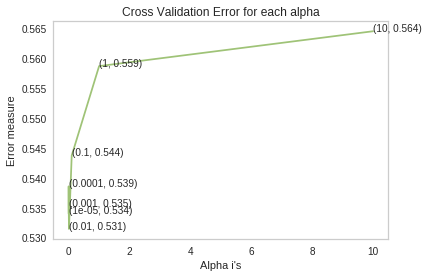

/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of best alpha =  0.01 The train log loss is: 0.5334705096700391
For values of best alpha =  0.01 The test log loss is: 0.5314540654472454
Total number of data points : 121287


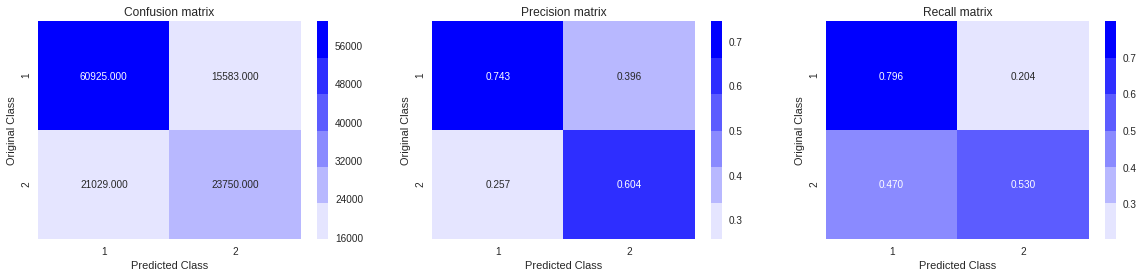

In [70]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  1e-05 The log loss is: 0.5363047774698695


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  0.0001 The log loss is: 0.5295260863331759


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  0.001 The log loss is: 0.5429052722456696


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  0.01 The log loss is: 0.543244304595971


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  0.1 The log loss is: 0.566266723339124


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  1 The log loss is: 0.5791897993340455


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self),

For values of alpha =  10 The log loss is: 0.6127265654427617


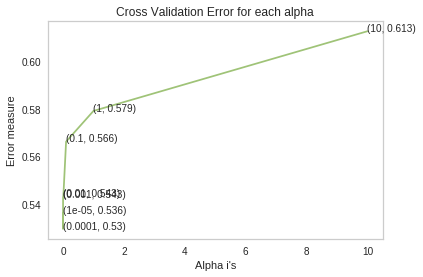

/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and t

For values of best alpha =  0.0001 The train log loss is: 0.531601884233322
For values of best alpha =  0.0001 The test log loss is: 0.5295260863331759
Total number of data points : 121287


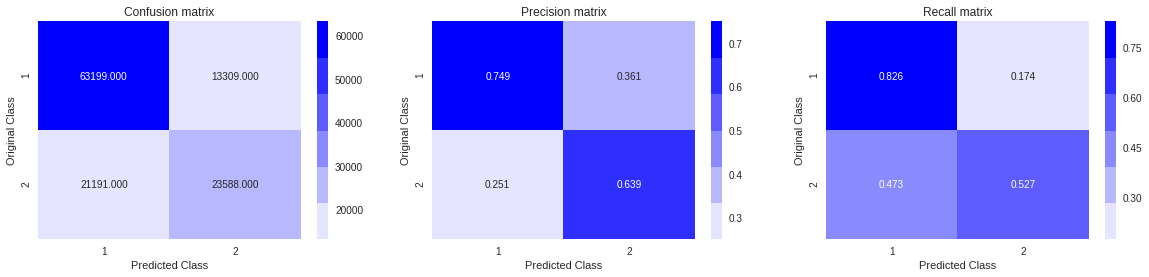

In [71]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Catboost is a new boosting library from yandex...it runs 5-10 faster than xgboost on gpu and overall known to givebetter results without **`parameter tuning`**.It also handles categorical var off the shelf..for more details here's a good talk from one of it's core developers (https://www.youtube.com/watch?v=oGRIGdsz7bM).How they handle categorical variables is worth looking into...


clf = catboost.CatBoostClassifier(depth=6, iterations=1000, learning_rate=0.1, thread_count=16, logging_level='Silent')
clf.fit(X_train, y_train)
predict_y = clf.predict_proba(X_test)[:,1]
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# let's do some debugging(knowing what's making a clf to predict certain outcomes and accordingly take actions to improve the performance)...this isn't a thorough one but just to get a feel for it.

model trained


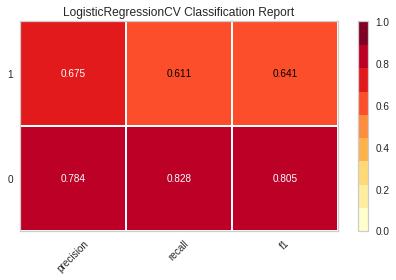

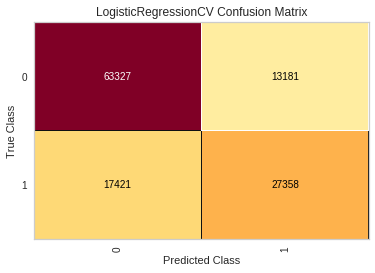

here's your ROC CURVE 



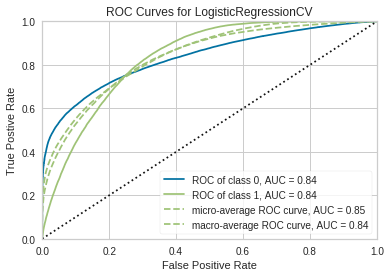

check out class-prediction errors 



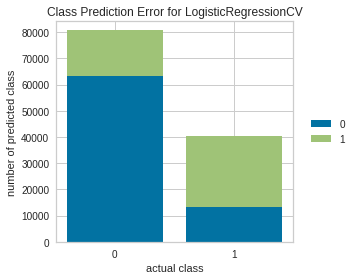

In [98]:
lr = LogisticRegressionCV()
model = perform_model(lr,X_train,y_train,X_test,y_test)

In [89]:
clf = model
proba_y_test_clf = clf.predict_proba(X_test)[:,1]
df_test = pd.DataFrame({'proba': proba_y_test_clf})
df_test['truth'] = y_test
df_test['abs_error'] = (df_test.truth - df_test.proba).abs()
df_test.head(5)

,proba,truth,abs_error
0,0.287781,1,0.712219
1,0.060714,0,0.060714
2,0.205890,1,0.794110
3,0.103411,0,0.103411
4,0.080920,0,0.080920


In [ ]:
# now we can arrange them by abs_error can go ahead to look at these id's for some insight....
